## Init

In [1]:
#! wget -O ./text_files.tar.gz 'https://piazza.com/redirect/s3?bucket=uploads&prefix=attach%2Fjlifkda6h0x5bk%2Fhzosotq4zil49m%2Fjn13x09arfeb%2Ftext_files.tar.gz' 
#! tar -xzf text_files.tar.gz
! pip install unidecode
! pip install torch

    100% |████████████████████████████████| 591.8MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61756000 @  0x7f009dc072a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
import unidecode
import string
import random
import time
import re
import pdb
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
from google.colab import drive

In [13]:
# Get all printable chars globally
all_characters = string.printable
n_characters = len(all_characters)

# Import from my drive
drive.mount('/drive')
file = unidecode.unidecode(open('/drive/My Drive/romance.txt').read())

# Store file length globally
file_len = len(file)
print('file_len =', file_len)

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
file_len = 2055928


## Modules

In [0]:
# RNN Module
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size, n_layers=1):
    super(RNN, self).__init__()
    # Store sizes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.output_size = output_size
    self.n_layers = n_layers

    # Init layers
    self.embed = nn.Embedding(input_size, hidden_size)
    self.gru = GRU(input_size, hidden_size)
    self.decode = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, input_char, hidden):
    out = self.embed(input_char).view(1, 1, -1) # Embed
    out, hid = self.gru(out, hidden) # Gru layer
    out = self.softmax(self.decode(out[0])) # Decode
    return out, hid

  def init_hidden(self):
    return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))
  
  
# GRU Layer Module
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(GRU, self).__init__()
    # Init weights
    self.weight_xr = Parameter(torch.Tensor(1, hidden_size, input_size).zero_())
    self.weight_hr = Parameter(torch.Tensor(1, hidden_size, hidden_size).zero_())
    self.weight_xz = Parameter(torch.Tensor(1, hidden_size, input_size).zero_())
    self.weight_hz = Parameter(torch.Tensor(1, hidden_size, hidden_size).zero_())
    self.weight_xh = Parameter(torch.Tensor(1, hidden_size, input_size).zero_())
    self.weight_hh = Parameter(torch.Tensor(1, hidden_size, hidden_size).zero_())
    
    # Init biases
    self.bias_r = Parameter(torch.Tensor(hidden_size).zero_())
    self.bias_z = Parameter(torch.Tensor(hidden_size).zero_())
    self.bias_h = Parameter(torch.Tensor(hidden_size).zero_())
    
    # Init nonlinearities 
    self.sigm = nn.Sigmoid()
    self.tanh = nn.Tanh()
    
  def forward(self, inp, hid): # Calculate new hidden layer using last and input char
    r = self.sigm(torch.matmul(inp, self.weight_xr) + 
                  torch.matmul(hid, self.weight_hr) + 
                  self.bias_r)
    z = self.sigm(torch.matmul(inp, self.weight_xz) + 
                  torch.matmul(hid, self.weight_hz) + 
                  self.bias_z)
    h = self.tanh(torch.matmul(inp, self.weight_xh) + 
                  torch.matmul(r * hid, self.weight_hh) + 
                  self.bias_h)
    out = z * hid + (1 - z) * h
    return out, out
    

## Methods

In [0]:
# Get a random chunk of text
def random_chunk():
  start_index = random.randint(0, file_len - chunk_len)
  end_index = start_index + chunk_len + 1
  return file[start_index:end_index]
  
# Convert text to char tensor
def char_tensor(string):
  tensor = torch.zeros(len(string)).long()
  for c in range(len(string)):
    tensor[c] = all_characters.index(string[c])
  return Variable(tensor)
  
# Get training set
def random_training_set():    
  chunk = random_chunk()
  inp = char_tensor(chunk[:-1])
  target = char_tensor(chunk[1:])
  return inp, target

# Train model on given training set
def train(inp, target):
  hidden = decoder.init_hidden()
  optimizer.zero_grad() # Zero out gradients
  
  loss = 0
  for c in range(chunk_len):
    output, hidden = decoder(inp[c].unsqueeze(0), hidden) # Predict
    loss += criterion(output, target[c].unsqueeze(0)) # Calculate loss

  loss.backward() # Backpropagate
  optimizer.step() # Take a step

  return loss.item() / chunk_len

# Test current model by creating novel text
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
  hidden = decoder.init_hidden()
  predicted = ""

  prime_input = char_tensor(prime_str)

  for p in range(len(prime_str) - 1): # Run input to init hidden layers
    _, hidden = decoder(prime_input[p], hidden)
  inp = prime_input[-1]

  for p in range(predict_len): # Make prediction
    output, hidden = decoder(inp, hidden) # Run model
    
    output_dist = output.data.view(-1).div(temperature).exp()
    top_i = torch.multinomial(output_dist, 1)[0]
    predicted += string.printable[top_i] # Add predication to string
    inp = top_i # Set last predication to next input

  return predicted

#def main(file)

## Main

[210.00184106826782 (1000 10%) 2.3181]
,
weld, I siss it. I some in says know.  But to the 
                                  out 
         

[419.6162543296814 (2000 20%) 2.0018]
dy you can't hanging it at looks on
head want the from her it a mother as Rosed of the back as       

[628.1878073215485 (3000 30%) 1.4610]
at
turns agains there's for the was, wather and me. You just it!

AMY
Whose a didn't wands the Great 

[837.6588652133942 (4000 40%) 0.4437]
ien poes her a kiss beging to was nods and
					note says it's the sayink to gues I war in the walk
 

[1047.8488011360168 (5000 50%) 0.8454]
.  Doying of he lalice to plard, canting, -, mound, rumbaching bellner-
you walk off
on you diding m 

[1255.9951181411743 (6000 60%) 1.8592]
ere breath.

                                                                    SHELAT (exte he wat 

[1465.3399374485016 (7000 70%) 1.0636]
at Rose broket in apprets a rack as aways 
			the dimming arricound any of the note his sleep and FR 

[1676.449

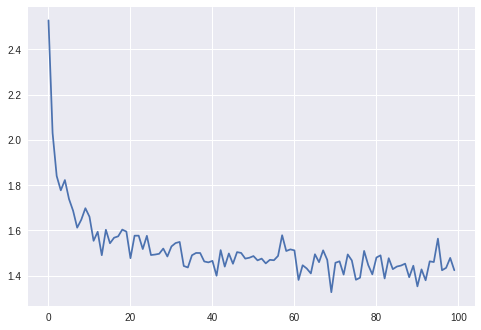

In [18]:
# Init parameters
n_epochs = 10000
print_every = 1000
plot_every = 100
hidden_size = 100
n_layers = 1
lr = .005
chunk_len = 200
 
# Init objects
decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

# Train for num epochs
for epoch in range(1, n_epochs + 1):
  inp, target = random_training_set()
  while len(inp) < chunk_len:
    inp, target = random_training_set()
  loss = train(inp, target) # Train on set
  loss_avg += loss

  if epoch == n_epochs:
    print(evaluate('Wh', 10000), '\n')
  elif epoch % print_every == 0: # Generate and print novel text
    print('[%s (%d %d%%) %.4f]' % (time.time() - start, epoch, epoch / n_epochs * 100, loss))
    print(evaluate('Wh', 100), '\n')

  if epoch % plot_every == 0: # Record loss
    all_losses.append(loss_avg / plot_every)
    loss_avg = 0
    
# Plot loss
plt.plot(all_losses)
plt.show()

## Alma Text

[25.129806518554688 (100 5%) 1.8055]
i and ined theod hond and the Mort ot sot the the the monm oflare the and the paglonst bin the sand  

[50.52747464179993 (200 10%) 1.8988]
ins thom ands the I they bey krany to themmank bowed couldy they repere there Now and Amulled they s 

[75.80857872962952 (300 15%) 1.7079]
t the who them dent on ratime the sinst cand, and his the stroy remansion all to begable beof and ar 

[101.07103872299194 (400 20%) 1.4006]
 the no who the also were eepentes no and chou had the came into beectainsureforth unto they is in t 

[126.28656792640686 (500 25%) 1.4889]
e, behold, and said to also gather, and that ye of God.

 Yea, I For of of Zamman for for broni the  

[151.5248568058014 (600 30%) 1.6297]
 who marden take give for the stich that cedon all show, them, that came that ye were all slain that 

[176.77148628234863 (700 35%) 1.2073]
 who mands over said them, the people soull all beat all thath their heir had suppen an his their Sp 

[202.062486410141 (800 40%) 1.3464]
 I sage the truch to the record their great to the roy.

 Now which they wickerning the had that the 

[227.35323286056519 (900 45%) 1.5688]
ore which was wass of Christ, ye know his are will according withate which in it were, and the somsa 

[252.4996359348297 (1000 50%) 1.1182]
 unto made, who would appoint them be a sour our affild, and when he warvusts that the cause and in  

[277.7070960998535 (1100 55%) 1.5369]
 hands, and to by struct over the things man and they would dectempll to they herd and the plan, and 

[302.64712619781494 (1200 60%) 1.4980]
 son know behold, the sencum shall what he was hadan, and the freath of Nephi, for the resice over o 

[327.84914922714233 (1300 65%) 1.3071]
or which them of mants, and shall pass taken of the vart, and the peoples, and the Nephites contanit 

[353.1599690914154 (1400 70%) 1.1575]
 that the winds. And by they had was in they well and the Lamanites; and thus hear not had a manish  

[378.41978001594543 (1500 75%) 1.4423]
er his to their desrith, that we should nots of men will among their have come of the Lamanites.

 A 

[403.691113948822 (1600 80%) 1.0202]
 the church the Nephites; for their shall number; according fathers. And Ammonihah them.

 Now he ha 

[429.03644466400146 (1700 85%) 1.8332]
ing that hand ever to mer their beleken and do not the faith, and to which the rightions, and grough 

[454.43994545936584 (1800 90%) 1.3129]
 the were stood us to so the land; and a should entend awerse to pass that they were and according i 

[479.8898298740387 (1900 95%) 1.3547]
 lif of the people of God mands on the Lamanites.

 And now which were into peace, and all this many 

[505.15928316116333 (2000 100%) 1.2315]
ore of the land of their brethren and was resurne them to kingry thou saith unto you, and the juck u 



## Portuguese Poetry

[25.456319570541382 (100 5%) 2.2392]
ompo nosca do bro role a ante A pergua, dado ar nom tersertra ce seutro de nosbelo e peris a do menn 

[50.71724319458008 (200 10%) 2.0535]
endo nos nos eusem sedem
En tem buro e foutres tremoss,  em Palemos mes troremcecos comos nao paros  

[76.20571875572205 (300 15%) 2.0781]
aca,
Com se que anto so miber taderes dino.

Quama bovo?

Nos deuses uma deuseve.

E as mancao.
Ta a 

[101.69660758972168 (400 20%) 1.8266]
am a queras,
E nao e nada Liha pento
Nem mai ou que que nao que a nos ou com cristar
A resto que qua 

[127.01482772827148 (500 25%) 1.9257]
ei.

AE NES E CONTAS

Tos nos vido, que a vera
E de nao que que a almo e umpre
Em que nem felhantes 

[152.5477797985077 (600 30%) 1.7756]
ao sorte
Se que que ano.
Que um sobrio,
Para imorto riam durozos.
Corte, os do mer mondemos do sol.
 

[178.00827050209045 (700 35%) 1.7094]
a,
Asse conscassa passo,
Que e atrer, as mais seja.

A mao aderanca anhassa,
A cada, estardada prans 

[203.60949611663818 (800 40%) 1.6055]
es
Deixadade dada
Com a vida,
Nem rio floros sem por outir fuis cortas
Sonqui Dunivezas conhesta.

N 

[229.19933605194092 (900 45%) 1.8301]
amos, campre imal de cam alheiro.
Faleca e a lerrezemos
Nao se nos sempre
Os peramos como ou moremos 

[254.68812322616577 (1000 50%) 1.6273]
istista
E serei no incerito nao terta teu lago, o me entra do quem com tudo o due antessa lenhos
O q 

[280.1664226055145 (1100 55%) 1.6620]
ario.
Em podisivente, dais pensa os outros deuses, suava
Ahfitadeio a lende
Na sol presse, tir so no 

[305.61323857307434 (1200 60%) 1.4461]
arca,
Com de difere
O tente, a mais escento ela ela e a os condece.
Ou conte ligeiros
Onde bronto a  

[331.0090298652649 (1300 65%) 1.8195]
e
Onde anteixo como ou sonto
Ma se que este concomos.

O INGURQUAS

E o enlata es conheces as deuse 

[356.2440617084503 (1400 70%) 1.4097]
udas
Da seja corde, teca, vanto.
Nao calma, o anos mestendos que por mais
Como ou tal ignora a saze
 

[381.6430940628052 (1500 75%) 1.4355]
eirise e vao e os deuses.

Vem maos outranguendos nos outros querem.
Nem mensa a ciente, me ponte do 

[407.13999032974243 (1600 80%) 1.8264]
iste.

Com a vida corre em ambra
O breve pesas nos naos indiferando das escratrestandos o mas incert 

[432.44232869148254 (1700 85%) 1.7410]
a taca.
Que lima vida, se espera como e alma,
Nem a sentil da que a vida,
Como o tem, entrazura infe 

[457.8426864147186 (1800 90%) 1.8323]
a, e a hora
Invivende e a inverno se achem
Do que e tor o suporentre e que corpo e ver pois outro on 

[483.1992087364197 (1900 95%) 1.5477]
aza
Solurra esconcemor dorge.

FUISTERO TUNHO A OTNO DA VORATA

Senha reterro a noite,
Se presente  

[508.5327904224396 (2000 100%) 1.6441]
ar apousegar
Usto nao tudo sempre ouseril descorrenca e oubrive.

MOR FALHA

Sobriamo-nos, nos prac 

